Importuję wszystko czego będę potrzebować

In [17]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch


Pobieram dane z datasetu i przerabiam je na tensory

In [24]:
train_data=datasets.MNIST(
    root="dane",
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data=datasets.MNIST(
    root="dane",
    train=False,
    transform=ToTensor(),
    download=True,
)

100.0%
100.0%
100.0%
100.0%


Sprawdzam co pobrałem i okazuje się że to 70k obrazków 28x28px z liczbami 0-9 

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

Tworzę słownik z train i test data loaderami

In [8]:
loaders={
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=False, num_workers=1),
}

Towrzę funkcję init w której mam 2 warstwy konwolucyjne i 2 FC a następnie funkcję forward która wykrywa cechy służące rozpoznawaniu liczb

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1=nn.Conv2d(1,10, kernel_size=5)
        self.conv2=nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320, 50)
        self.fc2=nn.Linear(50, 10)
    def forward(self, X):
        X=F.relu(F.max_pool2d(self.conv1(X), 2)) 
        X=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(X)), 2))
        X=X.view(-1, 320)
        X=F.relu(self.fc1(X))
        X=F.dropout(X, training=self.training)
        X=self.fc2(X)
        return F.softmax(X)
    

Zmieniam device na GPU jeśli to możliwe a następnie tworzę funkcje do trenowania i testowania modelu

In [14]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=CNN().to(device)

optimizer=optim.Adam(model.parameters(), lr=0.001)
loss_fn=nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for idx, (data, target) in enumerate(loaders['train']):
        data, target=data.to(device), target.to(device)
        optimizer.zero_grad()
        output=model(data)
        loss=loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if idx%20==0:
            print(f"Train Epoch: {epoch} [{idx * len(data)}/{len(loaders['train'].dataset)}] Loss: {loss.item():.6f}")
    
def test():
    model.eval()
        
    test_loss=0
    correct=0
        
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target=data.to(device), target.to(device)
            output=model(data)
            test_loss+=loss_fn(output, target).item()
            pred=output.argmax(dim=1, keepdim=True)
            correct+=pred.eq(target.view_as(pred)).sum().item()
    test_loss/=len(loaders['test'].dataset)  
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')
        
        

Trenuję i testuję model dla 11 epok

In [15]:
for epoch in range(1, 11):
    train(epoch)
    test()

C:\Users\pilcz\AppData\Local\Temp\ipykernel_9948\2897722950.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(X)


Train Epoch: 1 [0/60000] Loss: 2.303375
Train Epoch: 1 [2000/60000] Loss: 2.293479
Train Epoch: 1 [4000/60000] Loss: 2.201348
Train Epoch: 1 [6000/60000] Loss: 2.003416
Train Epoch: 1 [8000/60000] Loss: 1.891096
Train Epoch: 1 [10000/60000] Loss: 1.845345
Train Epoch: 1 [12000/60000] Loss: 1.760636
Train Epoch: 1 [14000/60000] Loss: 1.747607
Train Epoch: 1 [16000/60000] Loss: 1.757898
Train Epoch: 1 [18000/60000] Loss: 1.747696
Train Epoch: 1 [20000/60000] Loss: 1.690272
Train Epoch: 1 [22000/60000] Loss: 1.690586
Train Epoch: 1 [24000/60000] Loss: 1.648023
Train Epoch: 1 [26000/60000] Loss: 1.676679
Train Epoch: 1 [28000/60000] Loss: 1.667831
Train Epoch: 1 [30000/60000] Loss: 1.718425
Train Epoch: 1 [32000/60000] Loss: 1.710046
Train Epoch: 1 [34000/60000] Loss: 1.600942
Train Epoch: 1 [36000/60000] Loss: 1.644489
Train Epoch: 1 [38000/60000] Loss: 1.590836
Train Epoch: 1 [40000/60000] Loss: 1.647428
Train Epoch: 1 [42000/60000] Loss: 1.614542
Train Epoch: 1 [44000/60000] Loss: 1.579

Sprawdzam dla poszczególnego obrazu predykcje modelu

Predicted: 1


C:\Users\pilcz\AppData\Local\Temp\ipykernel_9948\2897722950.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(X)


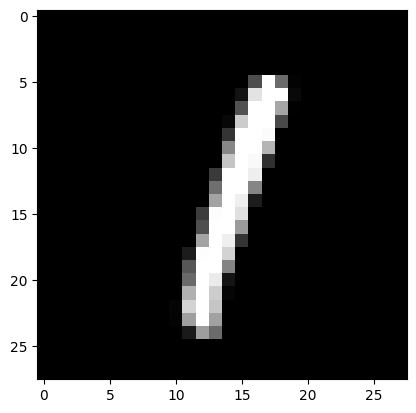

In [23]:
model.eval()
data, target=test_data[5]
data=data.unsqueeze(0).to(device)
output=model(data)
pred=output.argmax(dim=1, keepdim=True).item()
print(f'Predicted: {pred}')
image=data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()